In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 11 13:54:41 2020

@author: 

Read a dataset and train a model for classify the data.
"""
from Data_Preprocessing import ReadData
from ConvNet_Model import ConvNet
import numpy as np
import tensorflow.keras as keras
import sys, getopt
from High_Activated_Filters_CNN import HighlyActivated
import pandas
from itertools import *
from  functools import *
from Clustering import Clustering
from matplotlib import pyplot
import tensorflow.keras as keras
from matplotlib import pyplot
import numpy as np
from scipy import stats, integrate
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.spatial import distance
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(0)
#import deepwalk
def readData(data_name,dir_name):
    dir_path = dir_name + data_name+'/'
    dataset_path = dir_path + data_name +'.mat'
    
    ##read data and process it
    prepare_data = ReadData()
    prepare_data.data_preparation(dataset_path, dir_path)
    datasets_dict = prepare_data.read_dataset(dir_path,data_name)
    x_train = datasets_dict[data_name][0]
    y_train = datasets_dict[data_name][1]
    x_test = datasets_dict[data_name][2]
    y_test = datasets_dict[data_name][3]
    x_train, x_test = prepare_data.z_norm(x_train, x_test)
    nb_classes = prepare_data.num_classes(y_train,y_test)
    y_train, y_test, y_true = prepare_data.on_hot_encode(y_train, y_test)
    x_train, x_test, input_shape = prepare_data.reshape_x(x_train, x_test)  
    #create train validation subvalidation sub set
    x_training, x_validation = x_train[:90,:], x_train[90:,:]
    y_training, y_validation = y_train[:90,:], y_train[90:,:]
    
    x_training = x_train
    y_training = y_train
    
    return x_training, x_validation, x_test, y_training, y_validation, y_true, input_shape,nb_classes

def trainModel(x_training, x_validation, y_training, y_validation,input_shape, nb_classes):
    ##train the model
    train_model = ConvNet()
    #ResNet
    #model = train_model.networkResNet(input_shape,nb_classes)
    #FCN 
    model = train_model.network_fcN(input_shape,nb_classes)
    #cnn
    #model = train_model.network(input_shape,nb_classes)
    print(model.summary())
    train_model.trainNet(model,x_training,y_training,x_validation,y_validation,16,2000)
    return model,train_model

def predect(y_true,x_test,model,train_model,dimention_deactivated):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    keras.backend.clear_session()
    file = open('../Results/file_name.csv','a')
    file.write(str(dimention_deactivated))
    file.close()
    df_metrics = train_model.calculate_metrics(y_true, y_pred, 0.0)
    df = pandas.DataFrame(df_metrics).transpose()
    df.to_csv('../Results/file_name.csv', mode='a')
    return y_pred
    
def visulize_active_filter(model,x_test,y_true,nb_classes,train_model,cluster_centers,netLayers=3):
    ##visulize activated filters for the original testing dataset
    dimention_deactivated = 'all'
    y_pred = predect(y_true,x_test,model,train_model,dimention_deactivated)
    visulization = HighlyActivated(model,x_test,y_pred,nb_classes,netLayers=3)
    activation_layers = visulization.Activated_filters(example_id=1)
    visulization.get_high_activated_filters(activation_layers,dimention_deactivated)
    activated_class_cluster = visulization.show_high_activated_period(activation_layers,dimention_deactivated,cluster_centers)
    visulization.print_high_activated_combunation(activated_class_cluster)
    ##visulize activated filters when set all dimention of the data to zero, and just one with its original data
    x = []
    combination_id = []
    for i in range (x_test.shape[2]):
        x.append(i)
        tu = []
        tu.append(i)
        combination_id.append(tu)
    
    r = []
    for i in range(2,x_test.shape[2]):
        r.append(list(combinations(x, i)))
        
    for h in (r):
        for l in h:
            combination_id.append(l)
    print(combination_id)
    multivariate_variables = [[] for i in range(len(combination_id))]
    for i in range(len(combination_id)):
        multivariate_variables[i] = np.copy(x_test)
        for j in range(len(multivariate_variables[i])):      
            for k in range(len(multivariate_variables[i][j])):
                for n in range(x_test.shape[2]):
                    if (n not in combination_id[i]):
                        multivariate_variables[i][j][k][n] = 0
                    else:
                        dimention_deactivated =  ''.join(map(str,combination_id[i])) 
        y_pred = predect(y_true,multivariate_variables[i],model,train_model,dimention_deactivated)
        visulization = HighlyActivated(model,multivariate_variables[i],y_pred,nb_classes,netLayers=3)
        activation_layers = visulization.Activated_filters(example_id=1)
        visulization.get_high_activated_filters(activation_layers,dimention_deactivated)
        activated_class_cluster = visulization.show_high_activated_period(activation_layers,dimention_deactivated,cluster_centers)
        visulization.print_high_activated_combunation(activated_class_cluster)
        
def cluster_data_compenation(model,x_training,y_training,nb_classes):
    visulization_traning = HighlyActivated(model,x_training,y_training,nb_classes,netLayers=3)
    activation_layers = visulization_traning.Activated_filters(example_id=1)
    period_indexes, filter_number = visulization_traning.get_high_active_period(activation_layers)
    cluster_periods = visulization_traning.extract_dimention_active_period(period_indexes)
    ##clustring the periods
    cluster_data = []
  
    cluster_number = [12,11,13]
    #clustering = Clustering(cluster_periods)
    #print(new_data)
    kshape = KShape(n_clusters=12, verbose=True, random_state=42)
    trans_x = np.nan_to_num(cluster_periods[0])
    kshape.fit(trans_x)
    cluster_centers = kshape.cluster_centers_

    cluster_data.append(cluster_centers)

    x = []
    combination_id = []
    for i in range (x_training.shape[2]):
        x.append(i)
        tu = []
        tu.append(i)
        combination_id.append(tu)
    
    r = []
    for i in range(2,x_training.shape[2]):
        r.append(list(combinations(x, i)))
        
    for h in (r):
        for l in h:
            combination_id.append(l)
    multivariate_variables = [[] for i in range(len(combination_id))]
    for i in range(len(combination_id)):
        multivariate_variables[i] = np.copy(x_training)
        for j in range(len(multivariate_variables[i])):      
            for k in range(len(multivariate_variables[i][j])):
                for n in range(x_training.shape[2]):
                    if (n not in combination_id[i]):
                        multivariate_variables[i][j][k][n] = 0
                    else:
                        dimention_deactivated =  ''.join(map(str,combination_id[i])) 
        visulization_traning = HighlyActivated(model,x_training,y_training,nb_classes,netLayers=3)
        activation_layers = visulization_traning.Activated_filters(example_id=1)
        period_indexes, filter_number = visulization_traning.get_high_active_period(activation_layers)
        cluster_periods = visulization_traning.extract_dimention_active_period(period_indexes)
       
        kshape = KShape(n_clusters=12, verbose=True, random_state=42)
        trans_x = np.nan_to_num(cluster_periods[0])
        kshape.fit(trans_x)
        cluster_centers = kshape.cluster_centers_

        cluster_data.append(cluster_centers)
    
   #save the cluster center for each layer in different array
    cluser_center1 = []
    cluser_center2 = []
    cluser_center3 = []
    cluser_center = []
    l = 0
    for i in cluster_data: 
        for j in i:
            if(l == 0):
                cluser_center1.append(j)
            elif(l == 1):
                cluser_center2.append(j)
            else:
                cluser_center3.append(j)
        l +=1
    cluser_center.append(cluser_center1)
    cluser_center.append(cluser_center2)
    cluser_center.append(cluser_center3)
    #return cluser_center

    return cluser_center


def normilization(data):
        i = 0
        datt = []
        maxi = max(data)
        mini = abs(min(data))
        while (i< len(data)):
            
            if(data[i] >=0):
                val = data[i]/maxi
            else:
                val = data[i]/mini
         
            datt.append(val)
            i += 1
            
        return datt

#compare to cluster
def fitted_cluster(data,cluster):
        data = normilization(data)
        cluster[0] = normilization(cluster[0])
        mini = distance.euclidean(data,cluster[0])
        cluster_id = 0
        count = 0
        for i in (cluster):
            clu_nor = normilization(i)
            dist = distance.euclidean(data,clu_nor)
            if(dist < mini):
                cluster_id = count
                mini = dist
            count+=1
            
        return cluster_id




In [2]:
data_name = 'ArabicDigits'
dir_name = '../../Paper1/Data/mtsdata/'
x_training, x_validation, x_test, y_training, y_validation, y_true,input_shape, nb_classes = readData(data_name,dir_name)
model,train_model = trainModel(x_training, x_validation, y_training, y_validation,input_shape, nb_classes)
y_pred = predect(y_true,x_test,model,train_model,'alls')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 93, 13)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 93, 32)            3360      
_________________________________________________________________
batch_normalization (BatchNo (None, 93, 32)            128       
_________________________________________________________________
activation (Activation)      (None, 93, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 93, 64)            10304     
_________________________________________________________________
batch_normalization_1 (Batch (None, 93, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 93, 64)            0     

413/413 [==============================] - 5s 12ms/step - loss: 0.0084 - accuracy: 0.9968
Epoch 62/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0039 - accuracy: 0.9991
Epoch 63/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 64/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0020 - accuracy: 0.9998
Epoch 65/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 66/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 67/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 68/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0038 - accuracy: 0.9992
Epoch 69/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0042 - accuracy: 0.9985
Epoch 70/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0038 - 

413/413 [==============================] - 5s 11ms/step - loss: 0.0024 - accuracy: 0.9991
Epoch 140/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 141/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0026 - accuracy: 0.9986
Epoch 142/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0020 - accuracy: 0.9995
Epoch 143/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0024 - accuracy: 0.9997
Epoch 144/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0050 - accuracy: 0.9982
Epoch 145/500
413/413 [==============================] - 5s 11ms/step - loss: 7.7235e-04 - accuracy: 1.0000
Epoch 146/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 147/500
413/413 [==============================] - 5s 11ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 148/500
413/413 [==============================] - 5s 11ms/step - lo

413/413 [==============================] - 5s 13ms/step - loss: 8.2849e-04 - accuracy: 0.9997
Epoch 217/500
413/413 [==============================] - 5s 13ms/step - loss: 0.0019 - accuracy: 0.9992
Epoch 218/500
413/413 [==============================] - 6s 15ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 219/500
413/413 [==============================] - 6s 14ms/step - loss: 0.0019 - accuracy: 0.9991
Epoch 220/500
413/413 [==============================] - 5s 13ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 221/500
413/413 [==============================] - 6s 14ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 222/500
413/413 [==============================] - 6s 13ms/step - loss: 6.7571e-04 - accuracy: 0.9997
Epoch 223/500
413/413 [==============================] - 6s 13ms/step - loss: 6.1998e-04 - accuracy: 0.9997
Epoch 224/500
413/413 [==============================] - 5s 13ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 225/500
413/413 [==============================] - 5s 13ms/s

413/413 [==============================] - 5s 12ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 293/500
413/413 [==============================] - 5s 13ms/step - loss: 5.2902e-04 - accuracy: 0.9998 0s - loss: 5.5018e-04 - ac
Epoch 294/500
413/413 [==============================] - 5s 13ms/step - loss: 3.9630e-04 - accuracy: 0.9998
Epoch 295/500
413/413 [==============================] - 5s 13ms/step - loss: 1.5701e-04 - accuracy: 1.0000
Epoch 296/500
413/413 [==============================] - 5s 13ms/step - loss: 8.2152e-05 - accuracy: 1.0000
Epoch 297/500
413/413 [==============================] - 5s 13ms/step - loss: 0.0021 - accuracy: 0.9991
Epoch 298/500
413/413 [==============================] - 5s 12ms/step - loss: 5.9568e-04 - accuracy: 0.9998
Epoch 299/500
413/413 [==============================] - 5s 13ms/step - loss: 4.5235e-04 - accuracy: 0.9998
Epoch 300/500
413/413 [==============================] - 5s 13ms/step - loss: 0.0014 - accuracy: 0.9995
Epoch 301/500
413/413 [====

413/413 [==============================] - 5s 12ms/step - loss: 7.1837e-04 - accuracy: 0.9998
Epoch 369/500
413/413 [==============================] - 5s 12ms/step - loss: 2.3038e-04 - accuracy: 0.9998
Epoch 370/500
413/413 [==============================] - 5s 12ms/step - loss: 7.8024e-04 - accuracy: 0.9997
Epoch 371/500
413/413 [==============================] - 5s 12ms/step - loss: 6.6484e-05 - accuracy: 1.0000
Epoch 372/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0010 - accuracy: 0.9995
Epoch 373/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0017 - accuracy: 0.9997
Epoch 374/500
413/413 [==============================] - 5s 11ms/step - loss: 2.3213e-04 - accuracy: 1.0000
Epoch 375/500
413/413 [==============================] - 5s 12ms/step - loss: 5.7944e-05 - accuracy: 1.0000
Epoch 376/500
413/413 [==============================] - 5s 12ms/step - loss: 1.9903e-04 - accuracy: 1.0000
Epoch 377/500
413/413 [===========================

413/413 [==============================] - 5s 12ms/step - loss: 0.0013 - accuracy: 0.9994
Epoch 445/500
413/413 [==============================] - 5s 11ms/step - loss: 1.1999e-04 - accuracy: 1.0000
Epoch 446/500
413/413 [==============================] - 5s 12ms/step - loss: 6.5508e-04 - accuracy: 0.9998
Epoch 447/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0024 - accuracy: 0.9992
Epoch 448/500
413/413 [==============================] - 5s 12ms/step - loss: 8.9814e-05 - accuracy: 1.0000
Epoch 449/500
413/413 [==============================] - 5s 12ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 450/500
413/413 [==============================] - 5s 11ms/step - loss: 6.1473e-04 - accuracy: 0.9997
Epoch 451/500
413/413 [==============================] - 5s 12ms/step - loss: 8.4597e-04 - accuracy: 0.9995
Epoch 452/500
413/413 [==============================] - 5s 12ms/step - loss: 5.4545e-04 - accuracy: 0.9998
Epoch 453/500
413/413 [==============================]

In [3]:
x_validation.shape

(6510, 93, 13)

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 12 14:24:41 2020

@author: raneen_pc

This class will return the highly activated filters(feature map) for each layer in anetwork
"""
import tensorflow.keras as keras
from matplotlib import pyplot
import numpy as np
from scipy import stats, integrate
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.spatial import distance
import networkx as nx
from itertools import combinations
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_1samp
import scipy.stats as stats
import bisect
np.random.seed(0)

class HighlyActivated:
    def __init__(self, model,train_model,test_data,y_pred,nb_classes,netLayers):
        self.model = model
        self.x_test = test_data
        self.y_pred = y_pred
        self.nb_classes = nb_classes
        self.netLayers = netLayers
        self.train_model = train_model
        
    def Activated_filters(self,example_id):
        #layer_outputs = [layer.output for layer in self.model.layers[:self.netLayers+3]] 
        layer_outputs = [layer.output for layer in self.model.layers[:self.netLayers+6]] 
        # Extracts the outputs of the top n layers
        # Creates a model that will return these outputs, given the model input
        activation_model = keras.models.Model(inputs=self.model.input, outputs=layer_outputs) 
        activations = activation_model.predict(self.x_test)
        #shows the activated filters for each layer for an example

        #for i in range(0,self.netLayers+3):
        for i in range(0,self.netLayers+3):
            flag = False
            if i == 0:
            #or i == 1:
                activated_nodes = activations[i]
                flag = True
            #elif(i%2 == 1 and i >1):
            #    activated_nodes = activations[i]
            #    flag = True
            if(flag):
                n_filters, ix = activated_nodes.shape[2], 1
                for j in range(0,n_filters):
                        # specify subplot and turn of axis
                        ax = pyplot.subplot(n_filters, 3, ix)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        # plot filter channel
                        pyplot.plot(activated_nodes[example_id, :, j])
                        ix += 1
                pyplot.show()     
        return activations
                
    def get_best_distribution(sel,data):
        dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
        dist_results = []
        params = {}
        for dist_name in dist_names:
            dist = getattr(stats, dist_name)
            param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        dist_results.append((dist_name, p))
        # select the best fitted distribution
        best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
        return best_dist, best_p, params[best_dist]
    
    def change_dimention(self,x_test,num_dim):
        new_data = np.copy(x_test)
        for xe in range(len(x_test)):
            for i in range(len(new_data[xe])):
                    for n in num_dim:  
                            new_data[xe][i][n]=0  
        return new_data
    
    def predect(self,y_true,x_test,model):
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        keras.backend.clear_session()        
        return y_pred
    
    def get_dimention_MHAP(self,x_test):
        #dimention = [[] for i in range(self.nb_classes)]
        x_test_label = [[] for i in range(self.nb_classes)]
        y_test_label = [[] for i in range(self.nb_classes)]
        x = []
        x_test_copy = np.copy(x_test)
        combination_id = []
        for i in range (x_test_copy.shape[2]):
                x.append(i)
                tu = []
                tu.append(i)
                combination_id.append(tu)
            
        r = []
        for i in range(2,x_test_copy.shape[2]):
            r.append(list(combinations(x, i)))
                
        for h in (r):
            for l in h:
                combination_id.append(l)
        
        #combination_id all posible combination of the signal data
        #dim_test = []
        for z in range(len(self.y_pred)):
            index_label = self.y_pred[z]
            i = index_label.tolist().index(1) # i will return index of 2
            index_label = i
            x_test_label[index_label].append(x_test_copy[z])
            y_test_label[index_label].append(self.y_pred[z])
        
        combination_ids = []
        for i in combination_id:
            combination_ids.append(list(i))
        result_acc = []
        for i in combination_ids:
            ind = 0
            for js in x_test_label:
                xx = self.change_dimention(js,i)
                rounded_labels=np.argmax(y_test_label[ind], axis=1)
                y_pred = self.predect(rounded_labels,xx,self.model)
                result_acc.append(accuracy_score(rounded_labels, y_pred))
                ind +=1
        return result_acc
    
    def define_threshould(self,activations):
        threshoulds = [[] for i in range(self.netLayers)]
        layer_data = [[] for i in range(self.netLayers)]
        ff = True
        for j in range(len(self.x_test)):
            activated_id = 1
            filter_index = 0
            #layer_fil = []
            for l in range(1,self.netLayers+6):
                flag = False
                #get the id of the filter layer
                if(l == 1):
                    activated_id = 0
                    filter_index = 0
                    flag = True                    
                elif(l==4):
                    activated_id = 1
                    filter_index = 1
                    flag = True  
                elif(l==7):
                    activated_id = 2
                    filter_index = 2
                    flag = True
                #so make sure that we only have the id of conv layer
                if(flag):
                    activated_nodes = activations[l]
                    channel = [[] for i in range(activated_nodes.shape[2])]
                    #print(len(activated_nodes))
                    
                    for i in range(0,activated_nodes.shape[2]):
                        for k in (activated_nodes[j, :, i]):
                            channel[i].append(k)
                    
                    layer_data[filter_index].append(channel)
       
        #each layer has n-data and each n data has m filters 
        layer_data1 = [[] for i in range(self.netLayers)]
        channel_len = [32,64,128]
        for i in range(len(layer_data)):
            for l in range((channel_len[i])):
                layer_data1[i].append([])
            for j in range(len(layer_data[i])):
                for k in range(len(layer_data[i][j])):
                    for n in layer_data[i][j][k]:
                        layer_data1[i][k].append(n)
        #now we want to define a threshold for each filter of each array 
        for i in range(len(threshoulds)):
            mean_val = 0
            std_val = 0
            for l in range((channel_len[i])):
                threshoulds[i].append([])
                mean_val = np.mean(layer_data1[i][l])
                std_val = np.std(layer_data1[i][l])
                Q3 = np.percentile(layer_data1[i][l], 98)
                normal=stats.norm(loc=mean_val, scale=std_val)
                threshoulds[i][l].append(mean_val)
                threshoulds[i][l].append(std_val)
                threshoulds[i][l].append(normal)
                threshoulds[i][l].append(Q3)
                
        return threshoulds
    def define_threshould_all_filters(self,activations):
        threshoulds = [[] for i in range(self.netLayers)]
        layer_data = [[] for i in range(self.netLayers)]
        ff = True
        for j in range(len(self.x_test)):
            activated_id = 1
            filter_index = 0
            #layer_fil = []
            for l in range(1,self.netLayers+6):
                flag = False
                #get the id of the filter layer
                if(l == 1):
                    activated_id = 0
                    filter_index = 0
                    flag = True                    
                elif(l==4):
                    activated_id = 1
                    filter_index = 1
                    flag = True  
                elif(l==7):
                    activated_id = 2
                    filter_index = 2
                    flag = True
                #so make sure that we only have the id of conv layer
                if(flag):
                    activated_nodes = activations[l]
                    #channel = [[] for i in range(activated_nodes.shape[2])]
                    print(activated_nodes[j, :, i])
                    for i in range(0,activated_nodes.shape[2]):
                        for k in (activated_nodes[j, :, i]):
                            layer_data[filter_index].append(k)
                
        for i in range(len(threshoulds)):
            data_int = layer_data[i]
            sorted_integers = sorted(data_int)
            #for l in (len(layer_data[i])):
            mean_val = np.mean(layer_data[i])
            std_val = np.std(layer_data[i])
            Q3 = np.percentile(layer_data[i], 98)
            normal=stats.norm(loc=mean_val, scale=std_val)
            threshoulds[i].append(mean_val)
            threshoulds[i].append(std_val)
            threshoulds[i].append(normal)
            threshoulds[i].append(Q3)
            threshoulds[i].append(sorted_integers[-10])      
                
        return threshoulds
    
    def get_index_MHAP(self,activations,kernal_size=[]):
        #depends on the network archi
        #kernal_size = [8,5,3]
        kernal_size= kernal_size
        #initilize the array of the output (size will be based on output class label)
        #classes_lists = [[] for i in range(self.nb_classes)]
        filter_lists = [[] for i in range(self.netLayers)]
        filter_lists_index = [[] for i in range(self.netLayers)]
        period_active = []
        index_period_active = []
        #threshoulds = self.define_threshould_all_filters(activation_layers)
        threshoulds = self.define_threshould(activation_layers)
        #classes_lists_period = [[] for i in range(self.nb_classes)]
        #loop through each training sample
        for j in range(len(self.x_test)):
            #loop through each layer in the network
            # we need to take only the conv layers(not the conv and pooling)
            #so we take each second index of the loop
            activated_id = 1
            #len of the period_will depend on the lyer kernal size (first will be same and then multily of previous)
            Len_period = 8
            filter_index = 0
            #layer_fil = []
            for l in range(1,self.netLayers+6):
                flag = False
                #get the id of the filter layer
                if(l == 1):
                    Len_period = kernal_size[0]
                    filter_index = 0
                    flag = True                    
                elif(l==4):
                    Len_period = kernal_size[0] * kernal_size[1]
                    filter_index = 1
                    flag = True  
                elif(l==7):
                    Len_period = kernal_size[0]*kernal_size[1]*kernal_size[2]
                    filter_index = 2
                    flag = True
                #so make sure that we only have the id of conv layer
                if(flag):
                    #active id is what conv layer of network, 
                    #print(activated_id)
                    activated_nodes = activations[l]
                    #each filter of the data(activated_nodes.shape[2]) has (n values based on strid(inour case =1))                       
                    for i in range(0,activated_nodes.shape[2]):
                        index_k = 0
                        #loop throug the feature map
                        val = 0.8
                        for k in (activated_nodes[j, :, i]):
                            if(filter_index == 0):
                                val = 0.07
                            elif(filter_index==1):
                                #print(threshoulds[filter_index][i][2].pdf(k))
                                val = 0.15
                            else:
                                val = 0.05
                            #if(k >= threshoulds[filter_index][4]):
                            if(threshoulds[filter_index][i][2].pdf(k) >val):
                                #here pertubipt data from this index to len of period and get feature as mhap
                                #dimentions = self.get_dimention_MHAP(j,index_k,Len_period)
                                #dimentions = [1]
                                #here have an array to the periods, will be same as order(original traning data)
                                #each sample data will have periods from each dimention, for each layer
                                #[[[l1_p],[l2_p],[l3_p]],.....]
                                #print('ccc')
                                d1 =[]
                                #d2 =[]
                                #d3 =[]
                                #get each dimention data
                                for xe in(self.x_test[j]):
                                    d1.append(xe[0])
                                    #d2.append(xe[1])
                                    #d3.append(xe[2])
                                mhap1 = []
                                #mhap2 = []
                                #mhap3 = []
                                if(index_k+Len_period < len(d1)): 
                                    for l in range(index_k,index_k+Len_period):
                                        mhap1.append(d1[l])
                                        #mhap2.append(d2[l])
                                        #mhap3.append(d3[l])
    
                                filter_lists[filter_index].append(mhap1)
                                #filter_lists[filter_index].append(mhap2)
                                #filter_lists[filter_index].append(mhap3)
                                #add also what is time period
                                filter_lists_index[filter_index].append(index_k)               
                            index_k +=1

            period_active.append(filter_lists)        
            index_period_active.append(filter_lists_index)      
        return period_active,index_period_active
    
    def get_graph_MHAP(self,activations,kernal_size,cluster_central):
        kernal_size = [8,5,3]
        #initilize the array of the output (size will be based on output class label)
        #classes_lists = [[] for i in range(self.nb_classes)]    
        graph1 = nx.DiGraph()
        graph2 = nx.DiGraph()
        graph3 = nx.DiGraph()
        graph = nx.DiGraph()
        graph_data_each_sample = []
        node_assigned = []
        #threshoulds = self.define_threshould_all_filters(activation_layers)
        threshoulds = self.define_threshould(activation_layers)
        #loop through each training sample
        sample_cluster_mhap = []
        for j in range(len(self.x_test)):
            sample_x_graph=[]
            graph_layer_node = [[] for i in range(len(kernal_size))]
            index_layer = [[] for i in range(len(kernal_size))]
            #loop through each layer in the network
            # we need to take only the conv layers(not the conv and pooling)
            #so we take each second index of the loop
            activated_id = 1
            #len of the period_will depend on the lyer kernal size (first will be same and then multily of previous)
            Len_period = 8
            filter_index = 0
            layer_cluster_mhap = []
            for l in range(0,self.netLayers+6):
                flag = False
                #get the id of the filter layer
                if(l == 1):
                    activated_id = 0
                    Len_period = kernal_size[0]
                    filter_index = 0
                    flag = True                    
                elif(l==4):
                    activated_id = 1
                    Len_period = kernal_size[0] * kernal_size[1]
                    filter_index = 1
                    flag = True  
                elif(l==7):
                    activated_id = 2
                    Len_period = kernal_size[0]*kernal_size[1]*kernal_size[2]
                    filter_index = 2
                    flag = True
                #so make sure that we only have the id of conv layer
                if(flag):
                    #here use networkx to create the directed graph      
                    #active id is what conv layer of network, 
                    activated_nodes = activations[l]
                    #each filter of the data(activated_nodes.shape[2]) has (n values based on strid(inour case =1))                       
                    for i in range(0,activated_nodes.shape[2]):
                        index_k = 0
                        #loop throug the feature map
                        prev_node1 = ''
                        prev_node2 = ''
                        prev_node3 = ''
                        val = 0.8
                        for k in (activated_nodes[j, :, i]):
                            if(filter_index == 0):
                                val = 0.07
                            elif(filter_index==1):
                                #print(threshoulds[filter_index][i][2].pdf(k))
                                val = 0.15
                            else:
                                val = 0.05
                                
                            #if(k >= threshoulds[filter_index][4]):
                            if(threshoulds[filter_index][i][2].pdf(k) >val):
                                d1 =[]
                                #d2 =[]
                                #d3 =[]
                                #get each dimention data
                                for xe in(self.x_test[j]):
                                    d1.append(xe[0])
                                    #d2.append(xe[1])
                                    #d3.append(xe[2])
                                mhap1 = []
                                #mhap2 = []
                                #mhap3 = []
                                if(index_k+Len_period < len(d1)): 
                                    for l in range(index_k,index_k+Len_period):
                                        mhap1.append(d1[l])
                                        #mhap2.append(d2[l])
                                        #mhap3.append(d3[l])
                                index_layer[activated_id].append(index_k)
                                #here we have 3 MHAP we want to compre cluster
                                cluster_1 = ''
                                cluster_id_1 = ''
                                #cluster_2 = ''
                                #cluster_id_2 = ''
                                #cluster_3 = ''
                                #cluster_id_3 = ''
                                if(len(mhap1)):
                                    #print(mhap1)
                                    #here we cheack cluster fit, we want build graph (sampleX1->)
                                    #node_1,node2
                                    x_n = []
                                    x_n.append(mhap1)
                                    cluster_id_1 = self.fitted_cluster(mhap1,cluster_central[filter_index])
                                    #cluster_id_1 = cluster_central[filter_index].predict(x_n)
                                    #cluster_id_1 = cluster_id_1[0] 
                                    #print(cluster_id_1)
                                    #self.fitted_cluster(mhap1,cluster_central[filter_index])
                                    cluster_1 = 'layer%s %s'%((activated_id),(cluster_id_1))
                                    sample_x_graph.append(cluster_1)
                                #if(len(mhap1)):
                                #    cluster_id_2 = self.fitted_cluster(mhap2,cluster_central[filter_index])
                                #    cluster_2 = 'Layer_%s %s'%(activated_id,cluster_id_2)
                                #if(len(mhap1)):
                                #    cluster_id_3 = self.fitted_cluster(mhap3,cluster_central[filter_index])
                                #    cluster_3 = 'Layer_%s %s'%(activated_id,cluster_id_3)
                                
                                ################################################################# hooon
                                layer_previous = []
                                if(activated_id > 0 and (cluster_1 != '')):
                                    for ju in range(index_k,index_k+Len_period):
                                        index_layer_grap = 0 
                                        for ku in index_layer[activated_id-1]:
                                            if(ju == ku):
                                                #means this is also mhap from previous layer
                                                #print(graph_layer_node[activated_id-1][index_layer_grap])
                                                if(index_layer_grap < len(graph_layer_node[activated_id-1])):
                                                    layer_previous.append(graph_layer_node[activated_id-1][index_layer_grap])

                                            index_layer_grap +=1
                                    #print(layer_previous) 
                                if(cluster_1 == ''):
                                    pass
                                else:
                                    graph_layer_node[activated_id].append(cluster_1)
                                #sample_x_graph.append(cluster_1)
                                if(activated_id == 0):
                                    if(prev_node1 != '' and cluster_1 != ''):
                                        #here g . add edges
                                        if graph1.has_edge(prev_node1, cluster_1):
                                        # we added this one before, just increase the weight by one
                                            graph1[prev_node1][cluster_1]['weight'] += 1
                                            graph[prev_node1][cluster_1]['weight'] += 1
                                            
                                        else:
                                        # new edge. add with weight=1
                                            if(prev_node1 != '' and cluster_1 != ''):
                                                graph1.add_edge(prev_node1, cluster_1, weight=1)
                                                graph.add_edge(prev_node1, cluster_1, weight=1)
                                            #graph_layer_node[activated_id].append(cluster_1)
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                #here we cheack if layer_previous not empty we add all its node to the current graph node
                                #cluster_1
                                elif(activated_id ==1):
                                    #here we cheack if index mhap connect cluster id then we add edge
                                    if(prev_node1 != '' and cluster_1 != ''):
                                        if graph2.has_edge(prev_node1, cluster_1):
                                        # we added this one before, just increase the weight by one
                                            graph2[prev_node1][cluster_1]['weight'] += 1
                                            graph[prev_node1][cluster_1]['weight'] += 1
                                            if(layer_previous!=[]):
                                                for k in layer_previous:
                                                    if graph.has_edge(cluster_1,k):
                                                        graph[cluster_1][k]['weight'] += 1
                                                    else:
                                                        if(prev_node1 != '' and cluster_1 != ''):
                                                            graph.add_edge(cluster_1, k, weight=1)
                                            #graph_layer_node[activated_id].append(cluster_1)
                                        else:
                                        # new edge. add with weight=1
                                            graph2.add_edge(prev_node1, cluster_1, weight=1)
                                            graph.add_edge(prev_node1, cluster_1, weight=1)
                                            if(layer_previous!=[]):
                                                for k in layer_previous:
                                                    if graph.has_edge(cluster_1,k):
                                                        graph[cluster_1][k]['weight'] += 1
                                                    else:
                                                        if(prev_node1 != '' and cluster_1 != ''):
                                                            graph.add_edge(cluster_1, k, weight=1)
                                            #graph_layer_node[activated_id].append(cluster_1)
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                        if(layer_previous!=[]):
                                            for k in layer_previous:
                                                sample_x_graph.append(k)
                                        
                                else:
                                    if(prev_node1 != '' and cluster_1 != ''):
                                        if graph3.has_edge(prev_node1, cluster_1):
                                        # we added this one before, just increase the weight by one
                                            graph3[prev_node1][cluster_1]['weight'] += 1
                                            graph[prev_node1][cluster_1]['weight'] += 1
                                            #graph_layer_node[activated_id].append(cluster_1)
                                            if(layer_previous!=[]):
                                                for k in layer_previous:
                                                    if graph.has_edge(cluster_1,k):
                                                        graph[cluster_1][k]['weight'] += 1
                                                    else:
                                                        if(prev_node1 != '' and cluster_1 != ''):
                                                            graph.add_edge(cluster_1, k, weight=1)
                                        else:
                                        # new edge. add with weight=1
                                            graph3.add_edge(prev_node1, cluster_1, weight=1)
                                            graph.add_edge(prev_node1, cluster_1, weight=1)
                                            #graph_layer_node[activated_id].append(cluster_1)
                                            if(layer_previous!=[]):
                                                for k in layer_previous:
                                                    if graph.has_edge(cluster_1,k):
                                                        graph[cluster_1][k]['weight'] += 1
                                                    else:
                                                        if(prev_node1 != '' and cluster_1 != ''):
                                                            graph.add_edge(cluster_1, k, weight=1)
                                                        
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                        if(layer_previous!=[]):
                                            for k in layer_previous:
                                                sample_x_graph.append(k)
                                prev_node1 = 'layer%s %s'%((activated_id),(cluster_id_1))
                                #prev_node2 = cluster_2
                                #prev_node3 = cluster_3                                                           
                            index_k +=1   
                        #print('test_')
            sample_cluster_mhap.append(sample_x_graph)
        return graph,index_layer,sample_cluster_mhap

    def normilization(self,data):
        i = 0
        datt = []
        maxi = max(data)
        mini = abs(min(data))
        while (i< len(data)):
            
            if(data[i] >=0):
                val = data[i]/maxi
            else:
                val = data[i]/mini
         
            datt.append(val)
            i += 1
            
        return datt

    
    def fitted_cluster(self,data,cluster):
        data = self.normilization(data)
        cluster[0] = self.normilization(cluster[0])
        mini =0
        if(np.isnan(cluster[0]).any() == False & np.isinf(cluster[0]).any() == False):
            mini = distance.euclidean(data,cluster[0])
        cluster_id = 0
        count = 0
        for i in (cluster):
            clu_nor = self.normilization(i)
            if(np.isnan(clu_nor).any() == False & np.isinf(clu_nor).any() == False):
                dist = distance.euclidean(data,clu_nor)
                if(dist < mini):
                    cluster_id = count
                    mini = dist
                count+=1
        
        return cluster_id
    
    def get_segmant_MHAP(self,activations,kernal_size,cluster_central,n,sgmant_lenth):
        kernal_size = [8,5,3]
        #initilize the array of the output (size will be based on output class label)
        #classes_lists = [[] for i in range(self.nb_classes)]    
        #threshoulds = self.define_threshould_all_filters(activation_layers)
        threshoulds = self.define_threshould_all_filters(activation_layers)
        #loop through each training sample
        sample_cluster_mhap = []
        sgmant_lenth = sgmant_lenth
        start = 0
        n = n
        sgmant_lenth = sgmant_lenth
        intervals = np.arange(start, sgmant_lenth * n , sgmant_lenth)
        #print(intervals)
        for j in range(len(self.x_test)):
            graph_layer_node = [[] for i in range(len(kernal_size))]
            index_layer = [[] for i in range(len(kernal_size))]
            #print(j)
            #    break
            sample_x_graph=[]
            segmant = [[] for i in range(n)]
            interval = 0
            #loop through each layer in the network
            # we need to take only the conv layers(not the conv and pooling)
            #so we take each second index of the loop
            activated_id = 1
            #len of the period_will depend on the lyer kernal size (first will be same and then multily of previous)
            Len_period = 8
            filter_index = 0
            layer_cluster_mhap = []
            for l in range(0,self.netLayers+6):
                flag = False
                #get the id of the filter layer
                if(l == 1):
                    activated_id = 0
                    Len_period = kernal_size[0]
                    filter_index = 0
                    flag = True                    
                elif(l==4):
                    activated_id = 1
                    Len_period = kernal_size[0] * kernal_size[1]
                    filter_index = 1
                    flag = True  
                elif(l==7):
                    activated_id = 2
                    Len_period = kernal_size[0]*kernal_size[1]*kernal_size[2]
                    filter_index = 2
                    flag = True
                #so make sure that we only have the id of conv layer
                if(flag):
                    #here use networkx to create the directed graph      
                    #active id is what conv layer of network, 
                    activated_nodes = activations[l]
                    #each filter of the data(activated_nodes.shape[2]) has (n values based on strid(inour case =1))                       
                    for i in range(0,activated_nodes.shape[2]):
                        index_k = 0
                        #loop throug the feature map
                        prev_node1 = ''
                        prev_node2 = ''
                        prev_node3 = ''
                        val = 0.2
                        for k in (activated_nodes[j, :, i]):
                            if(filter_index == 0):
                                val = 0.07
                            elif(filter_index==1):
                            #    #print(threshoulds[filter_index][i][2].pdf(k))
                                val = 0.15
                            else:
                                val = 0.05
                                
                            if(k >= threshoulds[filter_index][3]):
                            #if(threshoulds[filter_index][i][3].pdf(k) >val):
                                #print('gg')
                                d1 =[]
                                d2 =[]
                                #d3 =[]
                                #get each dimention data
                                for xe in(self.x_test[j]):
                                    d1.append(xe[0])
                                    d2.append(xe[1])
                                    #d3.append(xe[2])
                                mhap1 = []
                                mhap2 = []
                                #mhap3 = []
                                if(index_k+Len_period < len(d1)): 
                                    for l in range(index_k,index_k+Len_period):
                                        mhap1.append(d1[l])
                                        mhap2.append(d2[l])
                                        #mhap3.append(d3[l])
                                index_layer[activated_id].append(index_k)
                                #here we have 3 MHAP we want to compre cluster
                                cluster_1 = ''
                                cluster_id_1 = ''
                                if(len(mhap1)):
                                    #print(mhap1)
                                    #here we cheack cluster fit, we want build graph (sampleX1->)
                                    #node_1,node2
                                    x_n = []
                                    x_n.append(mhap1)
                                    #print(len(cluster_central))
                                    #if(len(cluster_central[filter_index])):
                                    cluster_id_1 = self.fitted_cluster(mhap1,cluster_central[filter_index])
                                    cluster_1 = 'layer%s %s'%((activated_id),(cluster_id_1))
                                    if(index_k == 0):
                                        segmant[0].append(cluster_1)
                                    else:
                                        index_segma = bisect.bisect_left(intervals, index_k)-1
                                        #print()
                                        #print(index_segma)
                                        segmant[index_segma].append(cluster_1)
                                    sample_x_graph.append(cluster_1)
                                
                                ################################################################# hooon
                                layer_previous = []
                                if(activated_id > 0 and (cluster_1 != '')):
                                    for ju in range(index_k,index_k+Len_period):
                                        index_layer_grap = 0 
                                        for ku in index_layer[activated_id-1]:
                                            if(ju == ku):
                                                #means this is also mhap from previous layer
                                                #print(graph_layer_node[activated_id-1][index_layer_grap])
                                                if(index_layer_grap < len(graph_layer_node[activated_id-1])):
                                                    layer_previous.append(graph_layer_node[activated_id-1][index_layer_grap])

                                            index_layer_grap +=1
                                    #print(layer_previous) 
                                if(cluster_1 == ''):
                                    pass
                                else:
                                    graph_layer_node[activated_id].append(cluster_1)
                                #sample_x_graph.append(cluster_1)
                                if(activated_id == 0):
                                    if(prev_node1 != '' and cluster_1 != ''):
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                        if(index_k == 0):
                                            segmant[0].append(prev_node1)
                                            segmant[0].append(cluster_1)
                                        else:      
                                            index_segma = bisect.bisect_left(intervals, index_k)-1
                                            #print(index_segma)
                                            segmant[index_segma].append(prev_node1)
                                            segmant[index_segma].append(cluster_1)
                                #here we cheack if layer_previous not empty we add all its node to the current graph node
                                #cluster_1
                                elif(activated_id ==1):
                                    #here we cheack if index mhap connect cluster id then we add edge
                                    if(prev_node1 != '' and cluster_1 != ''):
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                        if(index_k == 0):
                                            segmant[0].append(prev_node1)
                                            segmant[0].append(cluster_1)
                                        else:      
                                            index_segma = bisect.bisect_left(intervals, index_k)-1
                                            #print(index_segma)
                                            segmant[index_segma].append(prev_node1)
                                            segmant[index_segma].append(cluster_1)
                                        if(layer_previous!=[]):
                                            for k in layer_previous:
                                                sample_x_graph.append(k)
                                                if(index_k == 0):
                                                    segmant[0].append(k)
                                                else:      
                                                    index_segma = bisect.bisect_left(intervals, index_k)-1
                                                    #print(index_segma)
                                                    segmant[index_segma].append(k)
                                        
                                else:
                                    if(prev_node1 != '' and cluster_1 != ''):                                                     
                                        sample_x_graph.append(prev_node1)
                                        sample_x_graph.append(cluster_1)
                                        if(index_k == 0):
                                            segmant[0].append(prev_node1)
                                            segmant[0].append(cluster_1)
                                        else:      
                                            index_segma = bisect.bisect_left(intervals, index_k)-1
                                            #print(index_segma)
                                            segmant[index_segma].append(prev_node1)
                                            segmant[index_segma].append(cluster_1)
                                        if(layer_previous!=[]):
                                            for k in layer_previous:
                                                sample_x_graph.append(k)
                                                if(index_k == 0):
                                                    segmant[0].append(k)
                                                else:      
                                                    index_segma = bisect.bisect_left(intervals, index_k)-1
                                                    #print(index_segma)
                                                    segmant[index_segma].append(k)
                                        
                                prev_node1 = 'layer%s %s'%((activated_id),(cluster_id_1))
                            index_k +=1   

            sample_cluster_mhap.append(segmant)
        return sample_cluster_mhap

In [5]:
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

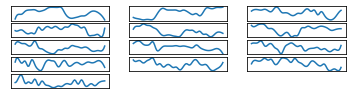

In [ ]:
visulization_traning = HighlyActivated(model,train_model,x_test,x_test,nb_classes,netLayers=3)
activation_layers = visulization_traning.Activated_filters(example_id=1)
#layer_a = visulization_traning.define_threshould(activation_layers,)
period_active,index_period_active = visulization_traning.get_index_MHAP(activation_layers,kernal_size=[8,5,3])
#x = visulization_traning.get_dimention_MHAP(x_validation)
#sample_cluster_mhap = visulization_traning.get_data_mhap(activation_layers,[8,40,120],read_cluster)
#layer_all = visulization_traning.define_threshould_all_filters(activation_layers,)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 11 11:43:54 2020

@author: Raneen_new
"""

from matplotlib import pyplot
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from kneed import KneeLocator
import numpy as np
from kneed import KneeLocator
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

class Clustering:
    def __init__(self,cluster_lists):
        self.cluster_lists = cluster_lists

    def scale_data(self,cluster_lists):
        i = 0
        if(cluster_lists != []):
            for data in cluster_lists:
                #print(len(cluster_lists[i]))
                for idx,seq in enumerate(data):
                    if(seq != []):
                        max_seq = max(seq)
                        min_seq = min(seq)
                        i = 0
                        while (i < len(seq)):
                            seq[i] = (seq[i] - min_seq) / (max_seq - min_seq)
                            i += 1
                    else:
                        data.pop(idx)
                i+=1        
        return cluster_lists

    def k_mean_clustering(self,num_clusters,data):
        kmeans = KMeans(init="random",n_clusters=num_clusters,n_init=10,max_iter=300,random_state=42)
        kmeans.fit(data)
        kmeans_kwargs = {"init": "random","n_init": 12,"max_iter": 300,"random_state": 42,}
        return kmeans.cluster_centers_

    def K_shape_clustering(self,num_clusters,data,layer_len):
        # Calculate length of maximal list
        n = len(max(data, key=len))
        # Make the lists equal in length
        lst_2 = [x + [0]*(n-len(x)) for x in data]
        a = np.nan_to_num(np.array(lst_2))
        print('K_shape_data')
        kshape = KShape(n_clusters=num_clusters, verbose=True, random_state=42)
        kshape.fit(a)
        name = 'MHAP_layer_data/cluster_center'+str(layer_len)+'.npy'
        np.save(name,kshape.cluster_centers_)
        return kshape.cluster_centers_
    
    def fancy_dendrogram(self,*args, **kwargs):
        max_d = kwargs.pop('max_d', None)
        if max_d and 'color_threshold' not in kwargs:
            kwargs['color_threshold'] = max_d
        annotate_above = kwargs.pop('annotate_above', 0)
    
        ddata = hac.dendrogram(*args, **kwargs)
    
        if not kwargs.get('no_plot', False):
            pyplot.title('Hierarchical Clustering Dendrogram (truncated)')
            pyplot.xlabel('sample index or (cluster size)')
            pyplot.ylabel('distance')
            for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
                x = 0.5 * sum(i[1:3])
                y = d[1]
                if y > annotate_above:
                    pyplot.plot(x, y, 'o', c=c)
                    pyplot.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                                 textcoords='offset points',
                                 va='top', ha='center')
            if max_d:
                pyplot.axhline(y=max_d, c='k')
        return ddata
    
    def print_clusters(self,timeSeries, Z, k, plot=False):
        # k Number of clusters I'd like to extract
        results = fcluster(Z, k, criterion='maxclust')
    
        # check the results
        s = pd.Series(results)
        clusters = s.unique()
    
        for c in clusters:
            cluster_indeces = s[s==c].index
            print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
            if plot:
                timeSeries.T.iloc[:,cluster_indeces].plot()
                pyplot.show()
        return clusters
    
    def hierarchical_cluster(self,num_clusters,data):
        #cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
        #cluster.fit_predict(data)
        # Do the clustering
        data = np.array(data)
        df = pd.DataFrame(data=data)
        data = df.dropna()
        Z = hac.linkage(data, method='complete', metric='euclidean')
        
        # Plot dendogram
        pyplot.figure(figsize=(25, 10))
        pyplot.title('Hierarchical Clustering Dendrogram')
        pyplot.xlabel('sample index')
        pyplot.ylabel('distance')
        """hac.dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=12,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
        )"""
        self.fancy_dendrogram(
            Z,
            truncate_mode='lastp',
            p=12,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,  # useful in small plots so annotations don't overlap
        )
        pyplot.show()
        return self.print_clusters(data, Z, num_clusters, plot=False)
    
    def DBscan_cluster(self,num_clusters,data):
        data = np.array(data)
        data[np.isnan(data)] = 0
        clustering = DBSCAN(eps=0.8, min_samples = 15).fit(data)
        return clustering
    
    def optic_cluster(self,num_clusters,data):
        data = np.array(data)
        data[np.isnan(data)] = 0
        clustering = OPTICS(min_samples=num_clusters).fit(data)
        return clustering
    
    def cluster_sequence_data(self,cluster_number,layer_len,cluser_data_pre_list1):
        # scale the data between 0 and 1
        cluster_centers = []
        cluster_lists = cluser_data_pre_list1
        
        #loop thriugh the periods for each CNN layer
        count = 0
        for layer in (cluster_lists):
            #cluster_centers.append(self.hierarchical_cluster(cluster_number[count],layer))
            #cluster_centers.append(self.k_mean_clustering(cluster_number[count],layer))
            cluster_centers.append(self.K_shape_clustering(cluster_number[count],layer,layer_len[count]))
            #cluster_centers.append(self.DBscan_cluster(cluster_number[count],layer))
            #cluster_centers.append(self.optic_cluster(cluster_number[count],layer))
            count +=1
        
        return  cluster_centers

In [ ]:
#now cluster the MHAP for each layer
#put the data of each layer in one array [[l1],[l2],[l3]]
cluser_data_pre_list = []
filter_lists = [[] for i in range(3)]
for i in range(len(period_active)):
    for j in range(len(period_active[i])):
        for k in range(len(period_active[i][j])):
            filter_lists[j].append(period_active[i][j][k])

cluser_data_pre_list.append([x for x in filter_lists[0] if x])
cluser_data_pre_list.append([x for x in filter_lists[1] if x])
cluser_data_pre_list.append([x for x in filter_lists[2] if x])
print(len(cluser_data_pre_list[0]))
print(len(cluser_data_pre_list[1]))
print(len(cluser_data_pre_list[2]))

In [ ]:
def downsample_to_proportion(rows, proportion=1):
        i = 0
        new_data = []
        new_data.append(rows[0])
        k = 0
        for i in (rows):
            if(k == proportion):
                new_data.append(i)
                k = 0
            k+=1
        return new_data 
cluser_data_pre_list1 = []
cluser_data_pre_list1.append(downsample_to_proportion(cluser_data_pre_list[0], 1000))
cluser_data_pre_list1.append(downsample_to_proportion(cluser_data_pre_list[1], 1000))
cluser_data_pre_list1.append(downsample_to_proportion(cluser_data_pre_list[2], 100))
cluser_data_pre_list1 = np.array(cluser_data_pre_list1)

clustering = Clustering(cluser_data_pre_list1)
cluser_data_pre_list1 = clustering.scale_data(cluser_data_pre_list1)
clustering = Clustering(cluser_data_pre_list1)
cluster_central = clustering.cluster_sequence_data([35,25,15],[8,40,120],cluser_data_pre_list1)

In [ ]:
import random
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

class Graph_embading:
    def __init__(self,graph):
        self.G = graph
        
    def save_graph(self,file_name):
        #initialze Figure
        graph = self.G
        plt.figure(num=None, figsize=(20, 20))
        plt.axis('off')
        fig = plt.figure(1)
        pos = nx.spring_layout(graph)
        color_map = []
        for node in G:
            layer0 = "Layer_0"
            layer1 = "Layer_1"
            layer2 = "Layer_2"

            if layer0 in node:
                color_map.append('blue')
            elif layer1 in node: 
                color_map.append('green') 
            else:
                color_map.append('red') 
        nx.draw_networkx_nodes(graph,pos,node_color=color_map)
        nx.draw_networkx_edges(graph,pos)
        nx.draw_networkx_labels(graph,pos)

        cut = 0.05
        xmax = cut * max(xx for xx, yy in pos.values())
        ymax = cut * max(yy for xx, yy in pos.values())
        plt.xlim(0, xmax)
        plt.ylim(0, ymax)

        plt.savefig(file_name,bbox_inches="tight")
        pylab.show()
        del fig

        #Assuming that the graph g has nodes and edges entered
        save_graph(g,"my_graph.pdf")
        
    def drwa_graph(self):
        # use one of the edge properties to control line thickness
        edgewidth = [ d['weight'] for (u,v,d) in self.G.edges(data=True)]
        # layout
        pos = nx.spring_layout(self.G)
        color_map = []
        for node in G:
            layer0 = "layer0"
            layer1 = "layer1"
            layer2 = "layer2"

            if layer0 in node:
                color_map.append('blue')
            elif layer1 in node: 
                color_map.append('green') 
            elif layer2 in node:
                color_map.append('red') 
            else:
                color_map.append('black')
        nx.draw_networkx_nodes(self.G, pos,node_size=100,node_color=color_map)
        nx.draw_networkx_edges(self.G, pos,)
        #nx.draw_networkx_edges(self.G, pos, width=edgewidth,edge_color=edgewidth)
        
    def draw_layer_graph(self,graph):
        G = graph
        # use one of the edge properties to control line thickness
        edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
        # layout
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos,node_size=100)
        nx.draw_networkx_edges(G, pos,)
        #nx.draw_networkx_edges(G, pos, width=edgewidth,edge_color=edgewidth)
        
    def get_node_list(self):
        nodes_list = np.array(list(self.G.nodes()))
        node_name = nodes_list[:]
        return node_name
        
    def get_rando_mwalk_node(self,node, path_length): 
        random_walk = [node]

        for i in range(path_length-1):
            temp = list(self.G.neighbors(node))
            temp = list(set(temp) - set(random_walk))    
            if len(temp) == 0:
                break

            random_node = random.choice(temp)
            random_walk.append(random_node)
            node = random_node

        return random_walk
    
    def randome_walk_nodes(self,node_name):
        # get list of all nodes from the graph
        all_nodes = list(self.G.nodes())

        random_walks = []
        for n in (node_name):
            for i in range(5):
                random_walks.append(self.get_rando_mwalk_node(n,15))
        # count of sequences
        return random_walks
    
    def embed_graph(self,random_walks):
        # train skip-gram (word2vec) model
        model_w2v = Word2Vec(window = 4, sg = 1, hs = 0,
                         negative = 10, # for negative sampling
                         alpha=0.03, min_alpha=0.0007,
                         seed = 14)

        model_w2v.build_vocab(random_walks, progress_per=2)

        model_w2v.train(random_walks, total_examples = model_w2v.corpus_count, epochs=20, report_delay=1)
        return model_w2v
    
    def plot_embaded_graph(self,model,word_list):
        X = model.wv[word_list]

        # reduce dimensions to 2
        pca = PCA(n_components=2)
        result = pca.fit_transform(X)


        plt.figure(figsize=(12,9))
        # create a scatter plot of the projection
        plt.scatter(result[:, 0], result[:, 1])
        for i, word in enumerate(word_list):
            plt.annotate(word, xy=(result[i, 0], result[i, 1]))

        plt.show()


In [ ]:
#G = nx.read_gpickle("graph_UWave.gpickle")
G,index,graph_data_sample = visulization_traning.get_graph_MHAP(activation_layers,[8,40,120],cluster_central)

In [ ]:
print(len(graph_data_sample))

In [ ]:
graph_embaded = Graph_embading(G)
graph_embaded.drwa_graph()
node_names = graph_embaded.get_node_list()
walks_nodes = graph_embaded.randome_walk_nodes(node_names)
print(walks_nodes)
embaded_graph = graph_embaded.embed_graph(walks_nodes)
graph_embaded.plot_embaded_graph(embaded_graph,node_names)

In [ ]:
#we have the graph, we empaded the nodes using deep walk
#now we want to test the model by go through the data, devideing it into segment
#for each segment we want to take its MHAP and then empade these nodes and added the empaded vector to array
#at each sample we will have (n embaded vector (depends on size of segment)).
#we take these n (order in time) and classifiy the ouput using LSTM, or GBoost classifier

In [ ]:
#define function of Time Series Embedding
def timeseries_embedding(embedding_graph,node_names,timesereis_MHAP,number_seg):
    feature_list = []
    embed_vector = embaded_graph.wv[node_names]
    for i,data in enumerate(timesereis_MHAP):
        #compare the name with word_list and take its embedding
        #loop through segmant
        segmant = [[] for i in range(number_seg)]
        #print(len(data))
        for m,seg in enumerate(data):
            temp = [0 for i in range(len(embed_vector[0]))]
            #each seg has mhaps
            for k,mhap in enumerate(seg):
                for j,node in enumerate(node_names):
                    if(mhap == node):
                        temp += embed_vector[j]
                        break
            segmant[m].append(list(temp))
        feature_list.append(segmant)
    return feature_list

In [ ]:
x_training.shape

In [ ]:
sample_cluster_mhap = visulization_traning.get_segmant_MHAP(activation_layers,[8,40,120],cluster_central,9,10)

In [ ]:
#np.save('MHAP_layer_data/segmant_MHAP_.npy',sample_cluster_mhap)

In [ ]:
new_feature = timeseries_embedding(graph_embaded,node_names,sample_cluster_mhap,9)

In [ ]:
#np.save('MHAP_layer_data/new_traning_x.npy',new_feature)

In [ ]:
x_train_feature = []
for m,data in enumerate (new_feature):
    segmant = []
    for j,seg in enumerate(data):
        segmant.append(seg[0])
    x_train_feature.append(segmant)

In [ ]:
#we need to convert the time series to 200*(15*100) as 2d to use xgboost)
x_train_new = []
for i, data in enumerate (x_train_feature):
    seg = []
    for j in (data):
        for k in j:
            seg.append(k)
    x_train_new.append(seg)

In [ ]:
y_true[0]

In [ ]:
y_train =y_true
#for i in y_true:
#    y_train.append(np.where(i==1)[0][0])

In [ ]:
#XGboost with 5 fold crosss validation
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
model = xgb.XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, x_train_new, y_true, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
#x_train_new,y_train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train_new, y_true, test_size=0.10)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
evallist = [(dtrain, 'train')]

In [ ]:
num_round = 100
param = {'max_depth': 5, 'eta': 1, 'objective': 'multi:softprob','num_class': nb_classes}
bst = xgb.train(param, dtrain, num_round, evallist)

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
ypred = bst.predict(dtest)

In [ ]:
y_pre =[]
for i in ypred:
    y_pre.append(np.argmax(i))

In [ ]:
#print())
#print(y_training[0])
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pre)